In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
pd.options.mode.chained_assignment = None 
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Import training data set
df = pd.read_excel('Train.xlsx')
df.head(5)

,Index,BI_RADS,Age,Shape,Margin,Mass_Density,Severity
0,1,5.0,67.0,lobular,spiculated,low,1
1,2,4.0,43.0,round,circumscribed,NaN,1
2,3,5.0,58.0,irregular,spiculated,low,1
3,4,4.0,28.0,round,circumscribed,low,0
4,5,5.0,74.0,round,spiculated,NaN,1


In [3]:
# Dataframe shape
df.shape

(811, 7)

In [4]:
# Data types
df.dtypes

Index             int64
BI_RADS         float64
Age             float64
Shape            object
Margin           object
Mass_Density     object
Severity          int64
dtype: object

In [5]:
# Drop index and BI_RADS
df = df.drop(['Index', 'BI_RADS'], axis=1)

In [6]:
# Dataframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811 entries, 0 to 810
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Age           723 non-null    float64
 1   Shape         781 non-null    object 
 2   Margin        764 non-null    object 
 3   Mass_Density  735 non-null    object 
 4   Severity      811 non-null    int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 31.8+ KB


In [7]:
# Null value counts for entire dataframe
predictors = list(df.columns)[:-1]
for p in predictors:
    n = df[p].isnull().sum()
    print(f'The {p} predictor has {n} null values')

The Age predictor has 88 null values
The Shape predictor has 30 null values
The Margin predictor has 47 null values
The Mass_Density predictor has 76 null values


In [8]:
# Dataframe describe Age variable
df['Age'].describe()

count    723.000000
mean      55.887967
std       16.886616
min        5.000000
25%       45.000000
50%       56.000000
75%       66.000000
max      130.000000
Name: Age, dtype: float64

Text(0.5, 1.0, 'Boxplot of Age Variable')

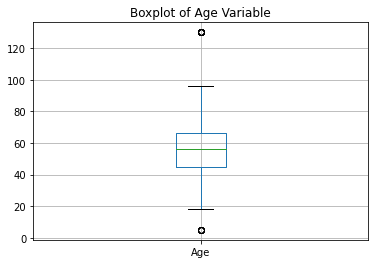

In [9]:
# Create boxplot of Age data
df.boxplot(column = 'Age') # Need to handle age outliers later
plt.title('Boxplot of Age Variable')

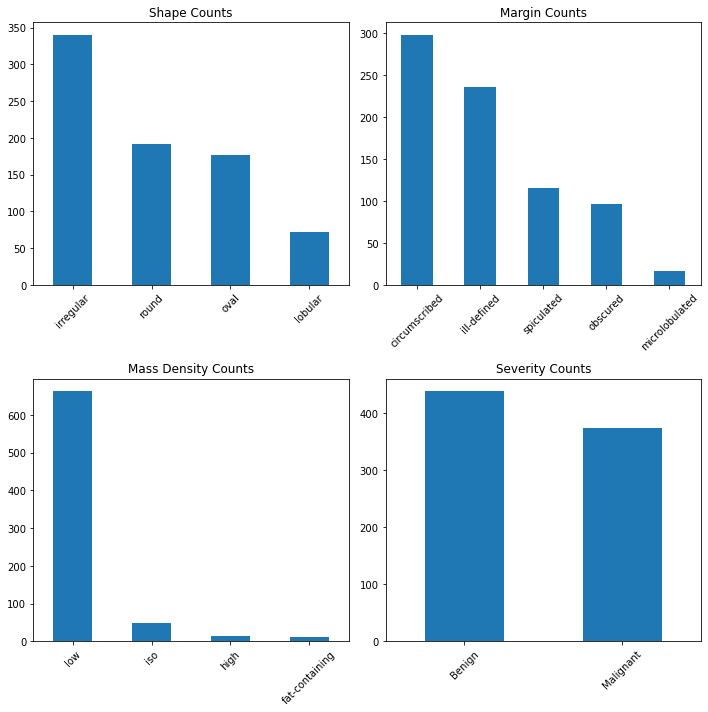

In [10]:
# Plot count values for qualitative data from entire dataframe
fig, axs = plt.subplots(2, 2)
df['Shape'].value_counts().plot.bar(ax = axs[0,0], rot=45)
axs[0,0].set_title('Shape Counts')
df['Margin'].value_counts().plot.bar(ax = axs[0,1], rot=45)
axs[0,1].set_title('Margin Counts')
df['Mass_Density'].value_counts().plot.bar(ax = axs[1,0], rot=45)
axs[1,0].set_title('Mass Density Counts')
df['Severity'].value_counts().plot.bar(ax = axs[1,1], rot=45)
axs[1,1].set_title('Severity Counts')
axs[1,1].set_xticklabels(('Benign', 'Malignant'))
#plt.tight_layout()
fig.set_figheight(10)
fig.set_figwidth(10)
plt.tight_layout()

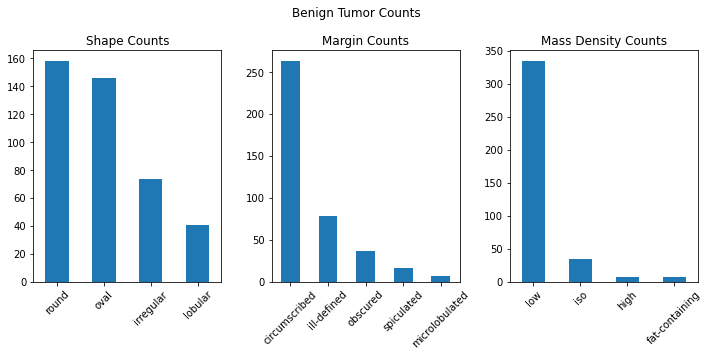

In [11]:
# Plot count data from benign tumors
ben_df = df[df['Severity'] == 0].reset_index(drop=True)
fig, axs = plt.subplots(1, 3)
ben_df['Shape'].value_counts().plot.bar(ax = axs[0], rot=45)
axs[0].set_title('Shape Counts')
ben_df['Margin'].value_counts().plot.bar(ax = axs[1], rot=45)
axs[1].set_title('Margin Counts')
ben_df['Mass_Density'].value_counts().plot.bar(ax = axs[2], rot=45)
axs[2].set_title('Mass Density Counts')
fig.set_figheight(5)
fig.set_figwidth(10)
plt.suptitle('Benign Tumor Counts')
plt.tight_layout()

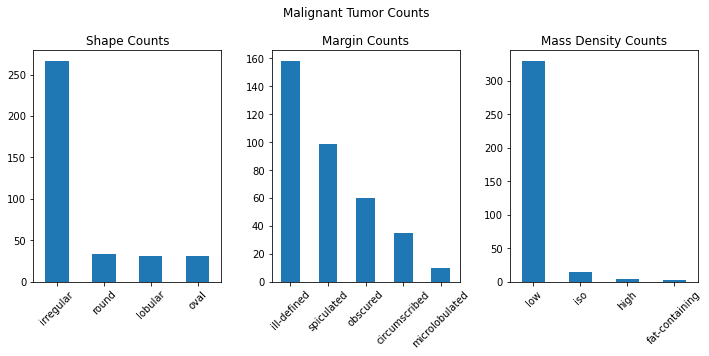

In [12]:
# Plot count data from malignant tumors
mal_df = df[df['Severity'] == 1].reset_index(drop=True)
fig, axs = plt.subplots(1, 3)
mal_df['Shape'].value_counts().plot.bar(ax = axs[0], rot=45)
axs[0].set_title('Shape Counts')
mal_df['Margin'].value_counts().plot.bar(ax = axs[1], rot=45)
axs[1].set_title('Margin Counts')
mal_df['Mass_Density'].value_counts().plot.bar(ax = axs[2], rot=45)
axs[2].set_title('Mass Density Counts')
fig.set_figheight(5)
fig.set_figwidth(10)
plt.suptitle('Malignant Tumor Counts')
plt.tight_layout()

In [13]:
# Address outlier ages by replacing with the average age given benign or malignant diagnosis
ben_avg_age = round(ben_df[(ben_df['Age'] >6) & (ben_df['Age'] <129)]['Age'].mean(),0)
mal_avg_age = round(mal_df[(mal_df['Age'] > 6) & (mal_df['Age'] < 129)]['Age'].mean(),0)

# Replace 5, 130, and null values ages with average
ben_df['Age'] = ben_df['Age'].replace([5,130, np.nan], ben_avg_age)
mal_df['Age'] = mal_df['Age'].replace([5,130, np.nan], mal_avg_age)

In [14]:
# Replace null values for Shapes

# For benign, randomly assign round or oval
ben_shape = ['round', 'oval']

for i, v in ben_df['Shape'].iteritems():
    if pd.isnull(v):
        n = np.random.choice(ben_shape)
        ben_df['Shape'][i] = n
        
# For malignant, assign irregular
mal_df['Shape'] = mal_df['Shape'].replace(np.nan, 'irregular')

In [15]:
# Replace null values for Margin

# For benign, assign circumscribed
ben_df['Margin'] = ben_df['Margin'].replace(np.nan, 'circumscribed')

# For malignant, randomly assign ill-defined or spiculated
mal_margin = ['ill-defined', 'spiculated']

for i, v in mal_df['Margin'].iteritems():
    if pd.isnull(v):
        n = np.random.choice(mal_margin)
        mal_df['Margin'][i] = n

In [16]:
# Replace null values for mass density with low
ben_df['Mass_Density'] = ben_df['Mass_Density'].replace(np.nan, 'low')
mal_df['Mass_Density'] = mal_df['Mass_Density'].replace(np.nan, 'low')

In [17]:
# Combine benign and malignant dataframes
new_df = pd.concat([ben_df, mal_df]).reset_index(drop=True)

# Shuffle rows
new_df = new_df.sample(frac=1).reset_index(drop=True)

In [54]:
# Create dummy variables and training data frame
shape_dums = pd.get_dummies(new_df['Shape'], drop_first=True)
margin_dums = pd.get_dummies(new_df['Margin'], drop_first=True)
mass_dums = pd.get_dummies(new_df['Mass_Density'], drop_first=True)
sev_dums = pd.get_dummies(new_df['Severity'], drop_first=True)

train_set = pd.concat([new_df, shape_dums, margin_dums, mass_dums, sev_dums], axis=1)
train_set.drop(['Shape', 'Margin', 'Mass_Density', 'Severity'], inplace = True, axis=1)
train_set.rename(columns = {'1' : 'Severity'}, inplace = True)

In [61]:
# Create training and test data sets
y = train_set.iloc[:, -1]
x = train_set.iloc[:, :-1]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 100)

In [82]:
# Support Vector Machine
model = SVC()
model.fit(x_train, y_train)
preds = model.predict(x_test)
print(f'The accuracy score is {round(accuracy_score(y_test, preds),2)}.\n')
print('The confusion matrix for the model: \n', confusion_matrix(y_test, preds))
print('\nThe classification report:\n', classification_report(y_test, preds))

The accuracy score is 0.74.

The confusion matrix for the model: 
 [[71 19]
 [24 49]]

The classification report:
               precision    recall  f1-score   support

           0       0.75      0.79      0.77        90
           1       0.72      0.67      0.70        73

    accuracy                           0.74       163
   macro avg       0.73      0.73      0.73       163
weighted avg       0.74      0.74      0.74       163



In [94]:
# Random Forest
clf = RandomForestClassifier(min_samples_leaf =3, random_state=0)
clf.fit(x_train, y_train)
preds = clf.predict(x_test)
print(f'The accuracy score is {round(accuracy_score(y_test, preds),2)}.\n')
print('The confusion matrix for the model: \n', confusion_matrix(y_test, preds))
print('\nThe classification report:\n', classification_report(y_test, preds))

The accuracy score is 0.85.

The confusion matrix for the model: 
 [[79 11]
 [14 59]]

The classification report:
               precision    recall  f1-score   support

           0       0.85      0.88      0.86        90
           1       0.84      0.81      0.83        73

    accuracy                           0.85       163
   macro avg       0.85      0.84      0.84       163
weighted avg       0.85      0.85      0.85       163

